In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import result_utils

In [2]:
name_A = 'Luhman 16A'; name_B = 'Luhman 16B'
color_A = '#FF622E'; color_B = '#396ED8'

lw_d = 0.8
lw_m = 1.0

res_alpha = 0.85

A = result_utils.RetrievalResults('../retrieval_outputs/freechem_K_A_ret_3/test_')
B = result_utils.RetrievalResults('../retrieval_outputs/freechem_K_B_ret_3/test_')

../retrieval_outputs/freechem_K_A_ret_3/test_data
  analysing data from ../retrieval_outputs/freechem_K_A_ret_3/test_.txt
../retrieval_outputs/freechem_K_B_ret_3/test_data
  analysing data from ../retrieval_outputs/freechem_K_B_ret_3/test_.txt


13C-16O__HITEMP


 50%|█████████████████████████████████████████████████▊                                                  | 996/2001 [00:19<00:19, 51.96it/s]

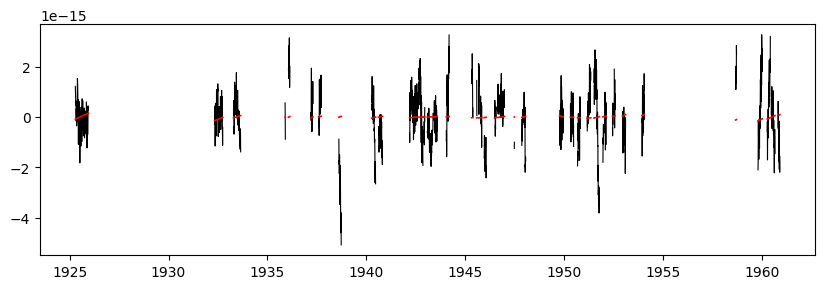

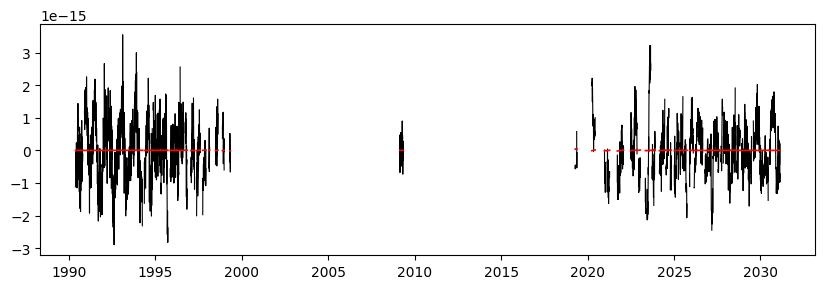

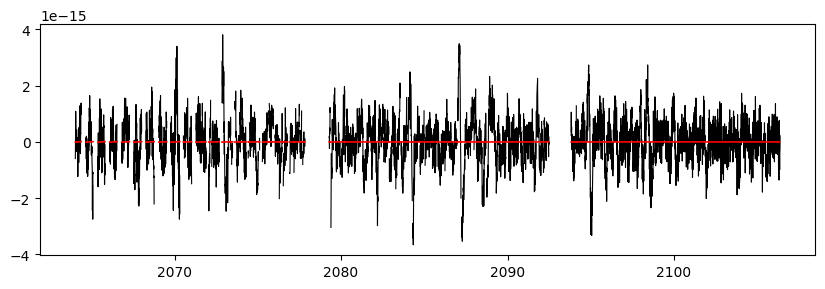

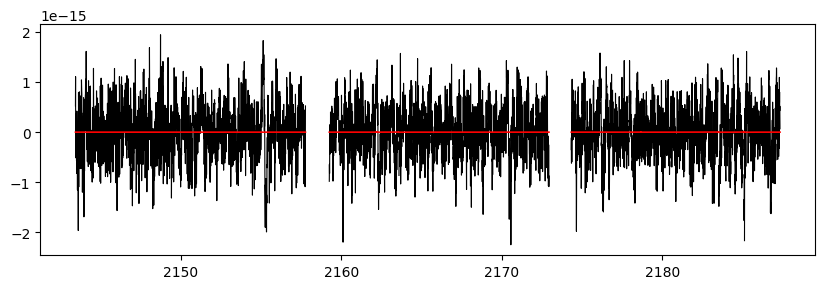

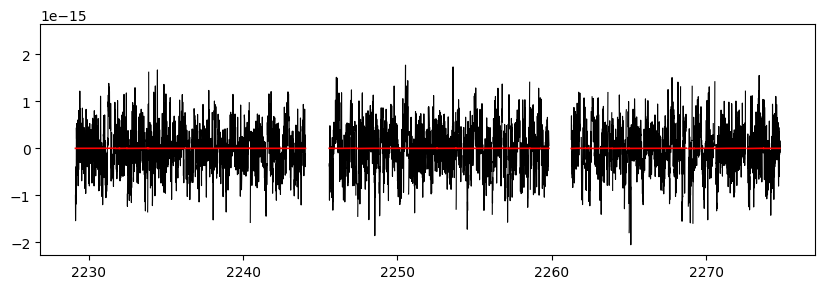

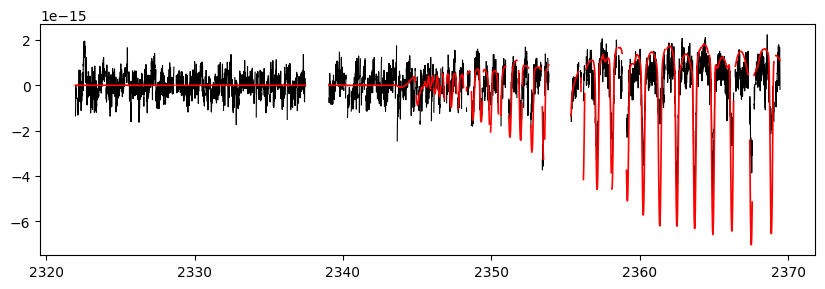

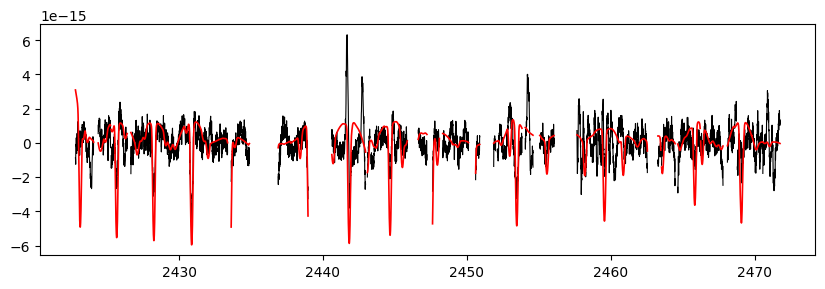

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:39<00:00, 51.06it/s]


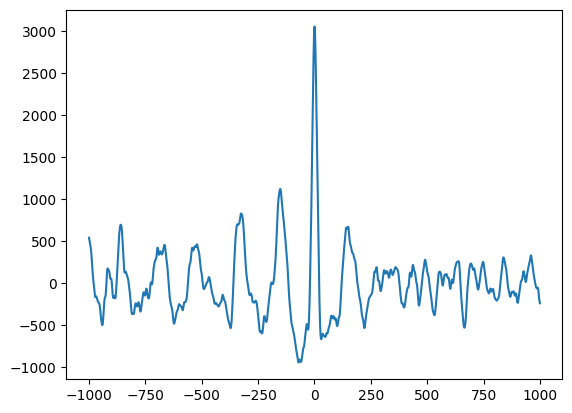

12C-18O__HITEMP


In [ ]:
import copy

def get_CCF(Res):
    
    Res.load_components(['Chem'])
    m_set = Res.model_settings[0]
    #all_line_species = np.array(Res.Chem[m_set].line_species)

    all_line_species = np.array([
        '13C-16O__HITEMP', '12C-18O__HITEMP', '12C-17O__HITEMP', '12C-1H4__MM', '14N-1H3__CoYuTe', '1H-19F__Coxon-Hajig', '1H2-32S__AYT2',
        '1H2-16O__POKAZATEL', '1H2-18O__HotWat78', '1H2-17O__HotWat78', '12C-16O__HITEMP',
        '12C-16O2__AMES', '1H-12C-14N__Harris', '23Na__Kurucz', '39K__Kurucz', 'H2', 'He'
        ])
    
    for line_species in all_line_species:
        
        print(line_species)
        if line_species in ['MMW','H2','He']:
            continue

        # Model w/o species X
        Res.get_model_spectrum([line_species])
        m_spec_to_subtract = copy.deepcopy(Res.m_spec_broad)

        # Model w/o all other species
        line_species_to_exclude = all_line_species[all_line_species != line_species]
        Res.get_model_spectrum(line_species_to_exclude)
        m_spec_template = copy.deepcopy(Res.m_spec_broad)

        '''
        Res.get_model_spectrum()
        
        fig, ax = plt.subplots(figsize=(10,3))
        for j in range(len(A.m_spec_broad[m_set].wave)):
            ax.plot(A.m_spec_broad[m_set].wave[j], A.m_spec_broad[m_set].flux[j], lw=1, c='k')
            ax.plot(m_spec_template[m_set].wave[j], m_spec_template[m_set].flux[j], lw=1, c='C0')
            ax.plot(m_spec_to_subtract[m_set].wave[j], m_spec_to_subtract[m_set].flux[j], lw=1, c='C1')
        ax.set(xlim=(2320,2370))
        plt.show()
        '''
        kwargs = dict(
            filter_type='savgol', window_length=301, polyorder=2, mode='interp', 
            )
        rv, CCF = Res.get_CCF(
            m_spec_template=m_spec_template, 
            m_spec_to_subtract=m_spec_to_subtract, 
            high_pass_filter={
                #'m_res': result_utils.HighPassFilter(), # Filter on model
                #'d_res': result_utils.HighPassFilter(), # Filter on data
                #'m_res': result_utils.HighPassFilter(filter_type='nanmedian', size=301), # Filter on model
                #'d_res': result_utils.HighPassFilter(filter_type='nanmedian', size=301), # Filter on data
                'm_res': result_utils.HighPassFilter(**kwargs), # Filter on model
                'd_res': result_utils.HighPassFilter(**kwargs), # Filter on data
                },
            )
        
        plt.plot(rv, CCF.sum(axis=-1))
        plt.show()

        if line_species.startswith('1H2'):
            break

get_CCF(A)